In [48]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [50]:
import os
import csv
import random
import torch
from torch.utils.data import Dataset, DataLoader

def read_csv_as_sequence(file_path):
    """
    Reads a CSV file with header 'Input,Output', and returns
    a list of (input_value, output_value) tuples.
    Each tuple represents one time step's data.
    """
    sequence = []
    with open(file_path, mode='r', encoding='utf-8') as f:
        reader = csv.reader(f)
        # Skip the header (assuming the first row is: Input,Output)
        header = next(reader, None)
        # Read each subsequent row
        for row in reader:
            input_val = float(row[0])
            output_val = float(row[1])
            sequence.append((input_val, output_val))
    return sequence

def load_all_sequences_from_folder(folder_path):
    """
    Iterates over all .csv files in the given folder,
    reads each CSV as a sequence, and stores them in a list.
    
    Returns:
        all_data: A list of sequences, where each sequence is
                  a list of (input, output) tuples.
    """
    all_data = []
    file_list = os.listdir(folder_path)
    csv_files = [f for f in file_list if f.lower().endswith('.csv')]
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        data_seq = read_csv_as_sequence(file_path)
        all_data.append(data_seq)
    return all_data

def split_train_val(all_data, val_ratio=0.2, shuffle=True):
    """
    Splits all_data (list of sequences) into train part and val part.
    If shuffle=True, randomly shuffle the sequence list before splitting.
    """
    if shuffle:
        random.shuffle(all_data)
    total = len(all_data)
    val_size = int(total * val_ratio)
    val_data = all_data[:val_size]
    train_data = all_data[val_size:]
    return train_data, val_data

def create_sliding_windows(sequence, lookback=20):
    """
    Each subsequence uses the input of the previous lookback step
    and uses the output of the lookback step as the target.
    """
    windows = []
    if len(sequence) < lookback:
        return windows
    for i in range(len(sequence) - lookback + 1):
        window = sequence[i : i + lookback]
        # uses the input of the previous lookback step
        inputs = [s[0] for s in window]
        # uses the output of the lookback step as the target.
        target = window[-1][1]
        windows.append((inputs, target))
    return windows

class SlidingWindowDataset(Dataset):
    """
    Use sliding window to generate a Dataset of subsequences
 
    """
    def __init__(self, data_list, lookback=20):
        self.windows = []
        for seq in data_list:
        
            if len(seq) >= lookback:
                self.windows.extend(create_sliding_windows(seq, lookback=lookback))
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        inputs, target = self.windows[idx]
        # convert inputs to tensor  shape(lookback-1, 1)
        x = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)
        # target convert to  tensor  shape(1,)
        y = torch.tensor([target], dtype=torch.float32)
        return x, y



In [51]:
# load
data_folder = "dataset"
all_data = load_all_sequences_from_folder(data_folder)

train_data, val_data = split_train_val(all_data, val_ratio=0.33, shuffle=True)

lookback = 50
train_dataset = SlidingWindowDataset(train_data, lookback=lookback)
val_dataset = SlidingWindowDataset(val_data, lookback=lookback)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False,num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=False,num_workers=8, pin_memory=True)



In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=4):
        super(LSTMModel, self).__init__()
     
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
       
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden=None):
        """
        x: (batch_size, seq_len, input_size)
        hidden: para for zero initialization
        """
        # LSTM out  shape(batch_size, seq_len, hidden_size)
        out, hidden = self.lstm(x, hidden)
        # Take the output of the last time step, the shape becomes (batch_size, hidden_size)
        out = out[:, -1, :]
        # The fully connected layer obtains the final prediction result, with shape (batch_size, 1)
        out = self.fc(out)
        return out, hidden

In [53]:
model = LSTMModel(input_size=1, hidden_size=64, num_layers=4)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [54]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
scaler = torch.cuda.amp.GradScaler()

epoch_loss = []
save_dir = "checkpoints20-20"
os.makedirs(save_dir, exist_ok=True)  
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

  
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

    accumulation_steps = 4
    for batch_idx, (batch_x, batch_y) in pbar:

        # batch_x = batch_x.to(device)
        # batch_y = batch_y.to(device)

        # with torch.cuda.amp.autocast():
        #     out, hidden = model(batch_x)
        #     loss = criterion(out, batch_y)

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        # 1) Move data to device (GPU)
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 2) Forward pass
        out, hidden = model(batch_x)
        loss = criterion(out, batch_y)

        # 3) Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # -- Gradient Accumulation -- 
        # out, hidden = model(batch_x)
        # loss = criterion(out, batch_y) / accumulation_steps  # 除以累積步數

        # loss.backward()

        # if (batch_idx + 1) % accumulation_steps == 0:
        #     optimizer.step()
        #     optimizer.zero_grad()
        # -- Gradient Accumulation -- 
        
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    epoch_loss.append(avg_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch+1}.pth"))

Epoch 1/20: 100%|██████████| 1869/1869 [00:14<00:00, 125.19it/s, loss=0.0032]

[Epoch 1/20] Avg Loss: 0.1187



Epoch 2/20: 100%|██████████| 1869/1869 [00:14<00:00, 125.50it/s, loss=0.0759]

[Epoch 2/20] Avg Loss: 0.0294



Epoch 3/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.04it/s, loss=0.0410]

[Epoch 3/20] Avg Loss: 0.0165



Epoch 4/20: 100%|██████████| 1869/1869 [00:14<00:00, 126.99it/s, loss=0.0187]

[Epoch 4/20] Avg Loss: 0.0110



Epoch 5/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.31it/s, loss=0.0046]

[Epoch 5/20] Avg Loss: 0.0227



Epoch 6/20: 100%|██████████| 1869/1869 [00:14<00:00, 126.62it/s, loss=0.0007]

[Epoch 6/20] Avg Loss: 0.0104



Epoch 7/20: 100%|██████████| 1869/1869 [00:14<00:00, 128.13it/s, loss=0.0166]

[Epoch 7/20] Avg Loss: 0.0109



Epoch 8/20: 100%|██████████| 1869/1869 [00:14<00:00, 128.26it/s, loss=0.0012]

[Epoch 8/20] Avg Loss: 0.0141



Epoch 9/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.59it/s, loss=0.0037]

[Epoch 9/20] Avg Loss: 0.0079



Epoch 10/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.72it/s, loss=0.0012]

[Epoch 10/20] Avg Loss: 0.0080



Epoch 11/20: 100%|██████████| 1869/1869 [00:14<00:00, 126.01it/s, loss=0.0293]

[Epoch 11/20] Avg Loss: 0.0083



Epoch 12/20: 100%|██████████| 1869/1869 [00:14<00:00, 126.58it/s, loss=0.0693]

[Epoch 12/20] Avg Loss: 0.0078



Epoch 13/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.21it/s, loss=0.0186]

[Epoch 13/20] Avg Loss: 0.0090



Epoch 14/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.37it/s, loss=0.0876]

[Epoch 14/20] Avg Loss: 0.0100



Epoch 15/20: 100%|██████████| 1869/1869 [00:14<00:00, 128.09it/s, loss=0.0020]

[Epoch 15/20] Avg Loss: 0.0077



Epoch 16/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.61it/s, loss=0.0027]

[Epoch 16/20] Avg Loss: 0.0063



Epoch 17/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.56it/s, loss=0.0044]

[Epoch 17/20] Avg Loss: 0.0077



Epoch 18/20: 100%|██████████| 1869/1869 [00:14<00:00, 126.55it/s, loss=0.0011]

[Epoch 18/20] Avg Loss: 0.0085



Epoch 19/20: 100%|██████████| 1869/1869 [00:14<00:00, 126.75it/s, loss=0.0010]

[Epoch 19/20] Avg Loss: 0.0078



Epoch 20/20: 100%|██████████| 1869/1869 [00:14<00:00, 127.06it/s, loss=0.0006]

[Epoch 20/20] Avg Loss: 0.0079


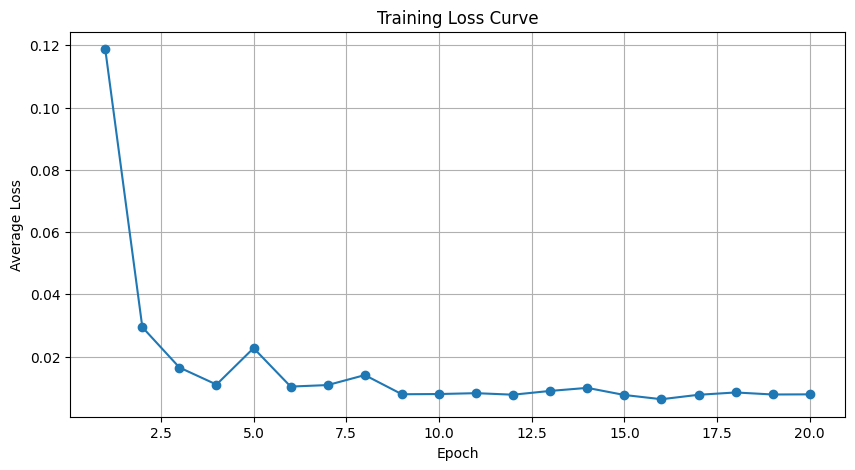

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

In [56]:

model.eval()
total_val_loss = 0.0

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # forward
        out, _ = model(batch_x)
        loss = criterion(out, batch_y)
        total_val_loss += loss.item()

avg_val_loss = total_val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")


Validation Loss: 0.0024


[683, 1124, 291, 1020, 1153, 1041, 133, 966, 63, 857]


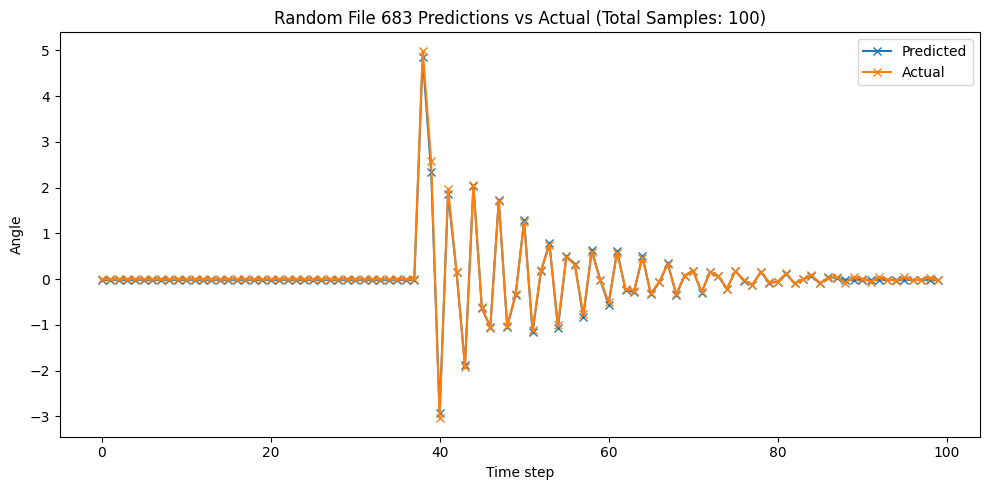

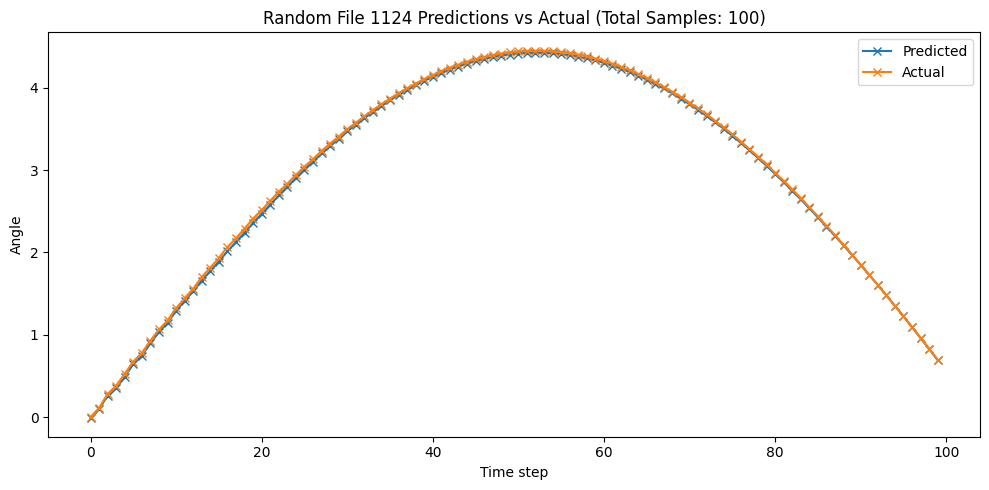

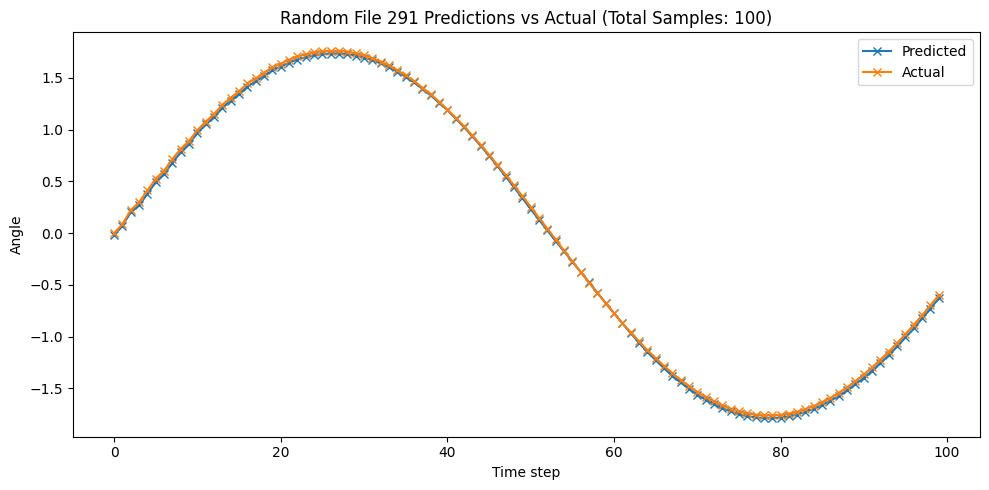

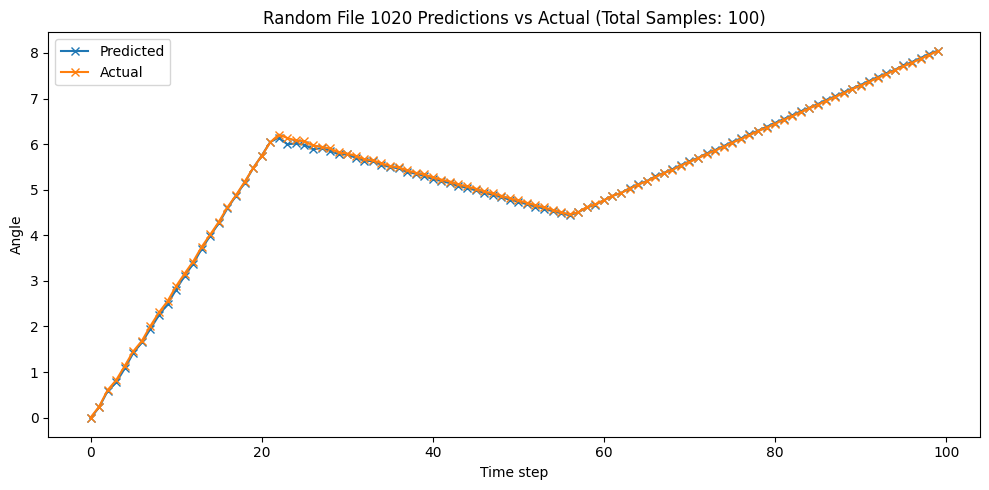

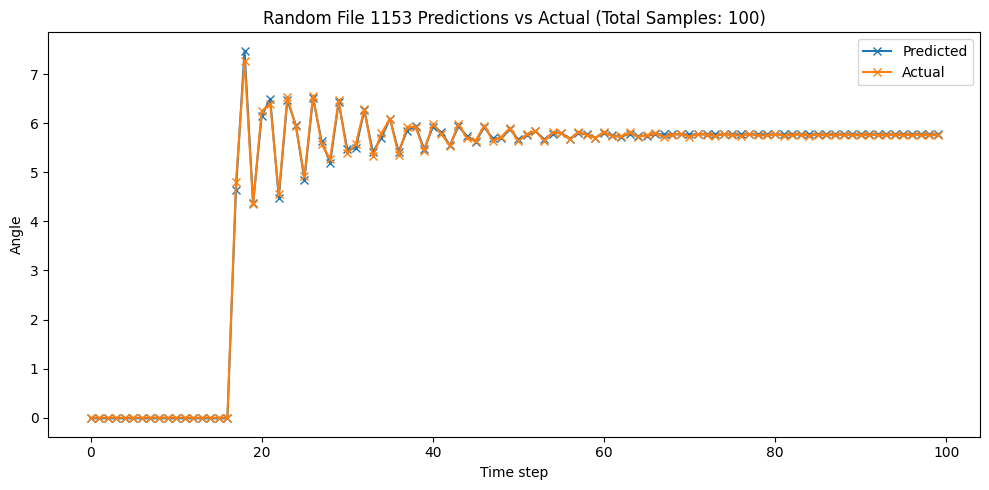

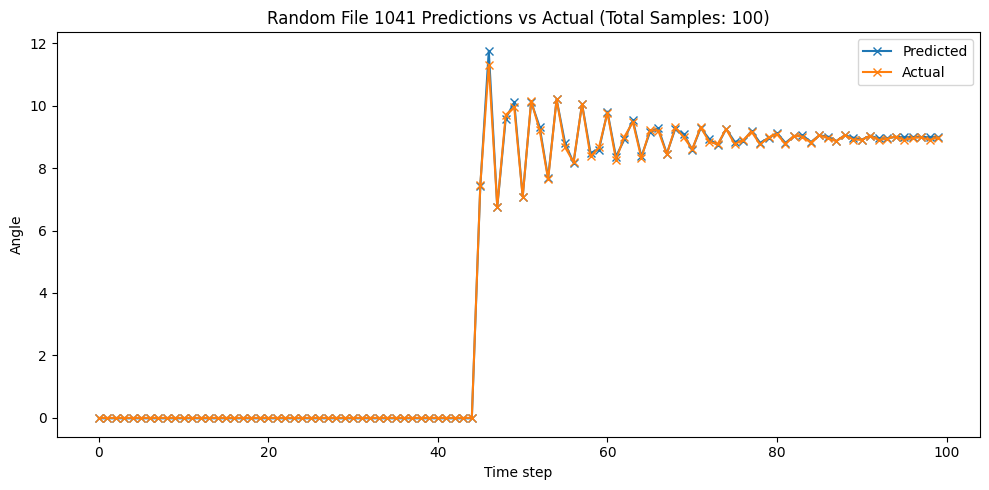

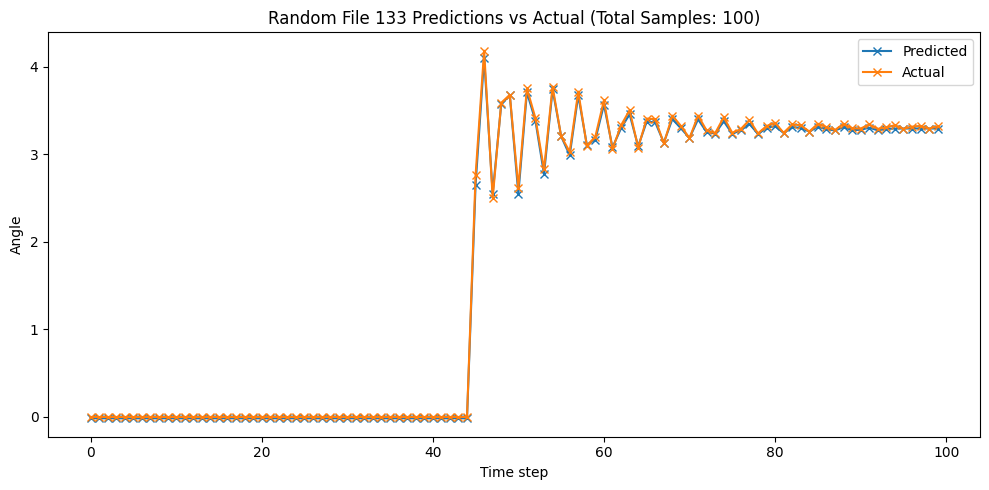

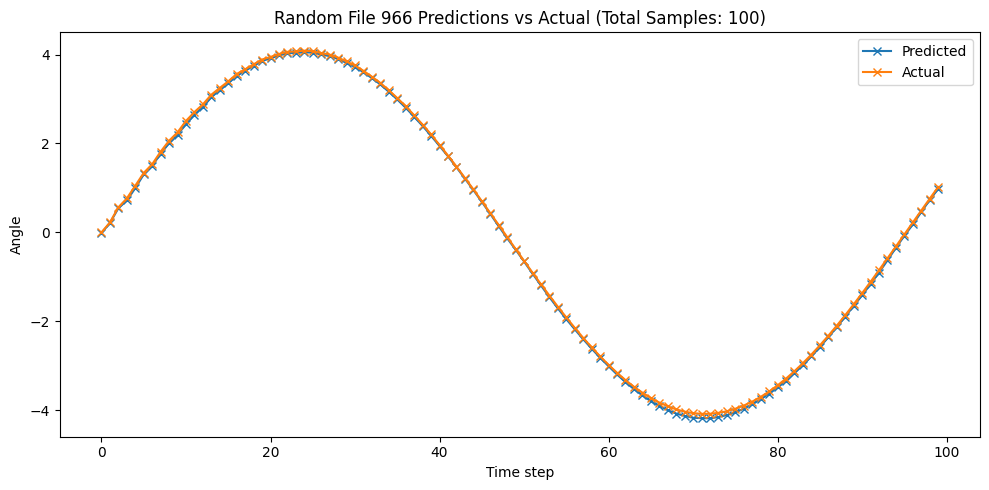

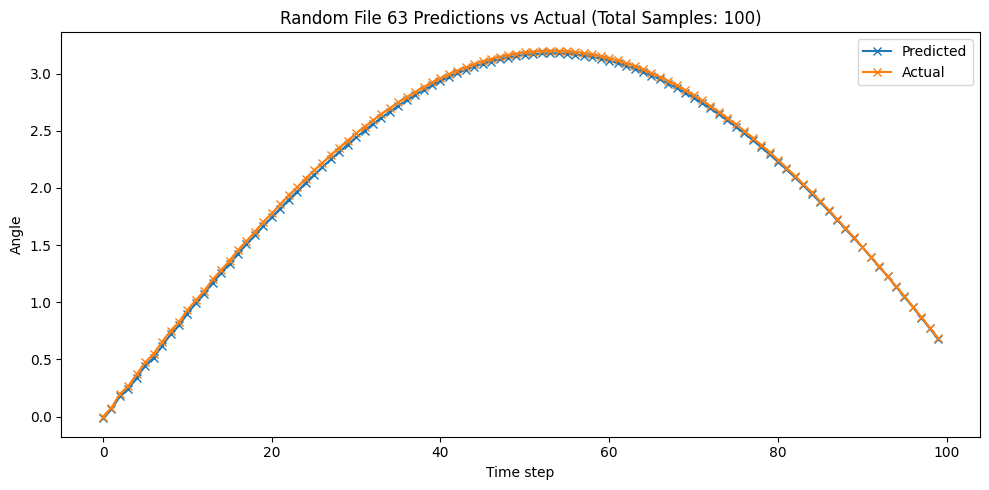

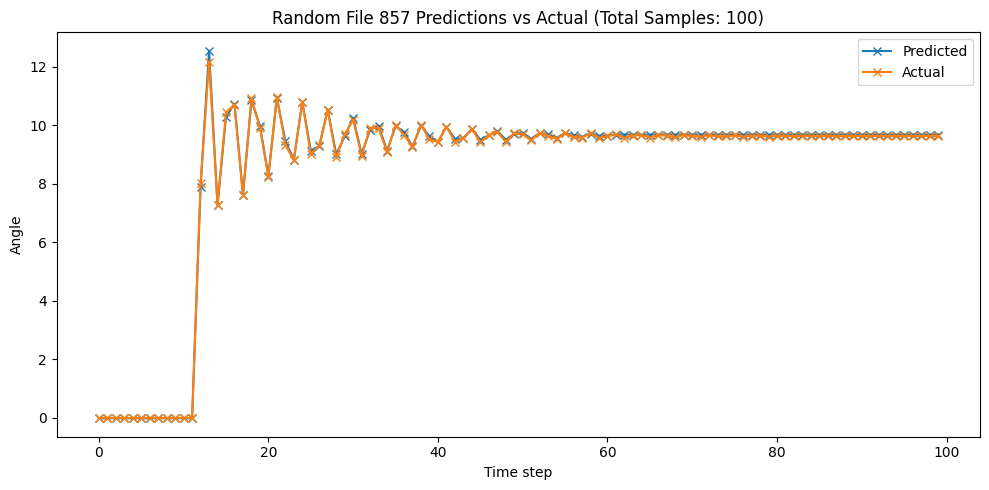

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import random
from collections import deque

# load model
model_path = "checkpoints20-20/model_epoch_10.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


num_files_to_plot = 10  # random chose 5
total_files = len(val_data)
if total_files < num_files_to_plot:
    selected_indices = list(range(total_files))
else:
    selected_indices = random.sample(range(total_files), num_files_to_plot)
for idx in selected_indices:
    seq = val_data[idx]  # choose seq
    
    # init q and pad with 0
    queue_length = 50
    input_queue = deque([0.0] * queue_length, maxlen=queue_length)
    
    preds = []  
    actuals = []
    
  
    for sample in seq:
        input_val, target_val = sample
        

        input_queue.append(input_val)
        
        # convert to tensor (1, 20, 1)
        input_tensor = torch.tensor(list(input_queue), dtype=torch.float32, device=device)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(-1)
        
        with torch.no_grad():
            pred, _ = model(input_tensor)
        pred_val = pred.squeeze().item()
        
        preds.append(pred_val)
        actuals.append(target_val)
       
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(preds)), preds, label="Predicted", marker='x')
    plt.plot(range(len(actuals)), actuals, label="Actual", marker='x')
    plt.title(f"Random File {idx} Predictions vs Actual (Total Samples: {len(preds)})")
    plt.xlabel("Time step")
    plt.ylabel("Angle")
    plt.legend()
    plt.tight_layout()
    plt.show()


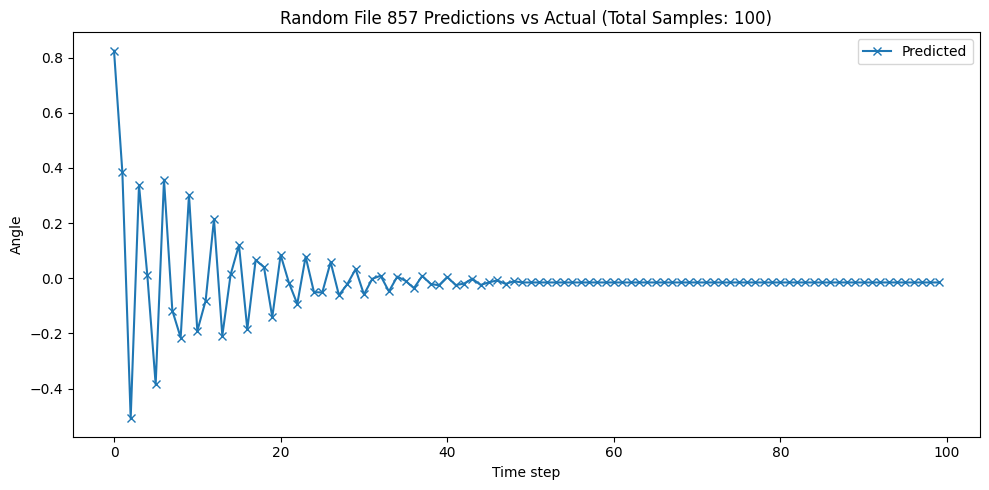

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490.]
[-0.48588371+0.00000000e+00j  0.99320782-4.78181347e-02j
  0.9780284 -9.69288942e-03j  0.98487395-1.36793938e-02j
  0.98282977-4.60541927e-03j  0.99080035-2.84066075e-03j
  1.00133484-3.57510456e-03j  1.00572269-1.19020573e-02j
  1.01480279-1.54622239e-02j  1.01638969-3.01393348e-02j
  1.01992991-3.39343692e-02j  1.02002014-5.16703621e-02j
  1.01459434-5.50281435e-02j  1.0140211 -6.84028807e-02j
  1.00309721-7.17583003e-02j  1.00093381-7.66918541e-02j
  0.99112848-7.95754565e-02j  0.98339052-7.82494471e-02j
  0.97737515-6.94620231e-02j  0.97924202-6.49340097e-02j
  0.97417006-5.71005726e-02j  0.97738196-4.24003426e-02j
  0.98442451-2.75462227e-02j  0.99761069-1.09547423e-02j
  1.01414502+8.04043866e-03j  1.04263616+3.11344862e-02j
  1.

In [73]:
import os
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import deque

# load model
model_path = "checkpoints20-20/model_epoch_10.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

impulse_input = np.zeros(100)  # 長度為 N 的零序列
impulse_input[0] = 1

# init q and pad with 0
queue_length = 50
input_queue = deque([0.0] * queue_length, maxlen=queue_length)

preds = []  
actuals = []


for sample in impulse_input:
    input_val = sample
    input_queue.append(input_val)
    
    # convert to tensor (1, 20, 1)
    input_tensor = torch.tensor(list(input_queue), dtype=torch.float32, device=device)
    input_tensor = input_tensor.unsqueeze(0).unsqueeze(-1)
    
    with torch.no_grad():
        pred, _ = model(input_tensor)
    pred_val = pred.squeeze().item()
    
    preds.append(pred_val)
       
    
plt.figure(figsize=(10, 5))
plt.plot(range(len(preds)), preds, label="Predicted", marker='x')
plt.title(f"Random File {idx} Predictions vs Actual (Total Samples: {len(preds)})")
plt.xlabel("Time step")
plt.ylabel("Angle")
plt.legend()
plt.tight_layout()
plt.show()

h_n = np.array(preds)
H_w = np.fft.fft(h_n)

N = len(h_n)
Ts = 1 / 1000
freqs = np.fft.fftfreq(N, d=Ts)

positive_freqs = freqs[freqs >= 0]
positive_H_w = H_w[freqs >= 0]
print(positive_freqs)
print(positive_H_w)


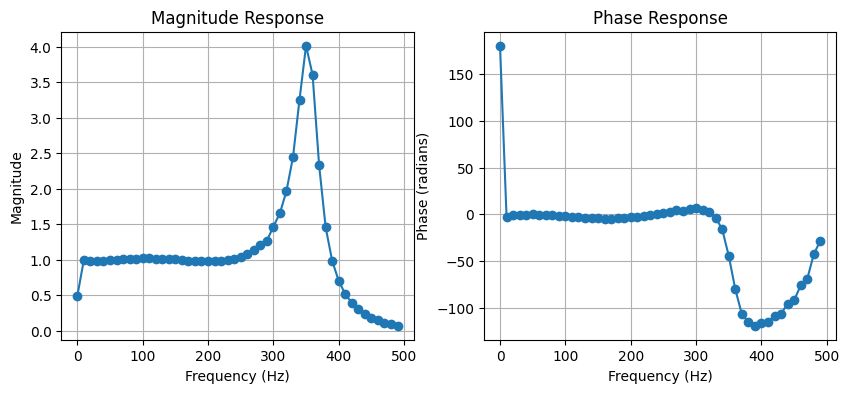

In [ ]:
import matplotlib.pyplot as plt

magnitude_response = np.abs(positive_H_w)  # 幅度響應
phase_response = np.degrees(np.angle(positive_H_w))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(positive_freqs, magnitude_response, marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Response')
plt.grid()

plt.subplot(1,2,2)
plt.plot(positive_freqs, phase_response, marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (angles)')
plt.title('Phase Response')
plt.grid()

plt.show()


In [113]:
import numpy as np


input_signal = np.array(impulse_input)
output_signal = np.array(preds) 

# 最小二乘法 (Least Squares Method)
order = 5

# Ax = Y
N = len(input_signal)
A = np.zeros((N - order, 2 * order))
Y = np.zeros(N - order)

for i in range(order, N):
    A[i - order, :order] = input_signal[i-order:i][::-1]
    A[i - order, order:] = -output_signal[i-order:i][::-1]
    Y[i - order] = output_signal[i]

coeffs, _, _, _ = np.linalg.lstsq(A, Y, rcond=None)

b_fit = coeffs[:order]
a_fit = np.concatenate(([1], coeffs[order:]))  # a[0] = 1

print("Estimated Numerator Coefficients (b):", b_fit)
print("Estimated Denominator Coefficients (a):", a_fit)


Estimated Numerator Coefficients (b): [ 0.00000000e+00  1.66533454e-16  5.55111512e-17  0.00000000e+00
 -1.36941955e-01]
Estimated Denominator Coefficients (a): [ 1.         -0.08554526 -0.05911126 -0.76150444  0.11223667 -0.1953592 ]


Transfer Function H(z):

                            -0.1369
----------------------------------------------------------------
z^5 - 0.08555 z^4 - 0.05911 z^3 - 0.7615 z^2 + 0.1122 z - 0.1954

dt = 0.001



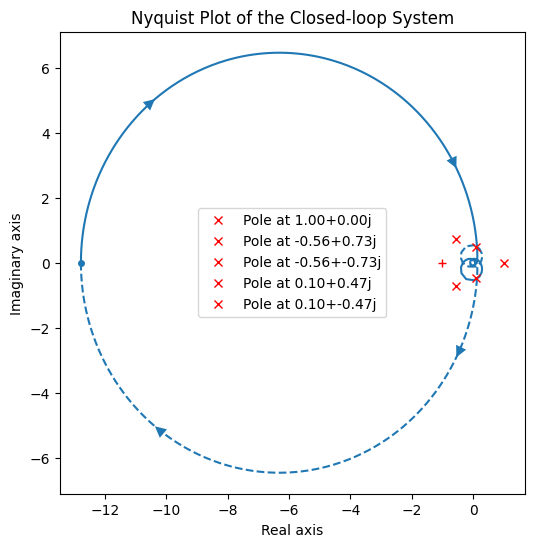

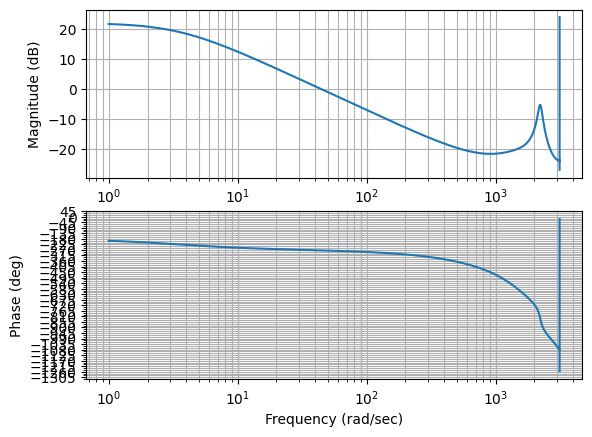

In [114]:
import numpy as np
import control as ctrl


threshold = 1e-6

b_fit = coeffs[:order]  # 分子係數
b_fit = np.array([coef if abs(coef) >= threshold else 0 for coef in b_fit])

a_fit = np.concatenate(([1], coeffs[order:]))  # 分母係數，a[0] 必須是 1
a_fit = np.array([coef if abs(coef) >= threshold else 0 for coef in a_fit])

Ts = 0.001  # 取樣時間

# 創建離散轉移函數 H(z) = b(z) / a(z)
H_z = ctrl.TransferFunction(b_fit, a_fit, Ts)

# 輸出轉移函數
print("Transfer Function H(z):")
print(H_z)

# ----------  Nyquist  ----------
plt.figure(figsize=(6, 6))
ctrl.nyquist(H_z)
plt.title("Nyquist Plot of the Closed-loop System")

zeros = H_z.zeros().tolist()
poles = H_z.poles().tolist()
for zero in zeros:
    plt.plot(zero.real, zero.imag, 'go', label=f'Zero at {zero.real:.2f}+{zero.imag:.2f}j')
for pole in poles:
    plt.plot(pole.real, pole.imag, 'rx', label=f'Pole at {pole.real:.2f}+{pole.imag:.2f}j')


plt.legend()
plt.grid()
plt.show()

# ----------  Bode plot ----------
plt.figure()
ctrl.bode(H_z, dB=True)
plt.show()


Fitted Zeros: [-3.41453580e+01+4.06665338e+01j  1.47762260e+00+3.64332228e+00j
  2.25048002e+00+9.07815052e+00j  1.08538033e+01-2.20271114e+00j
 -2.54155554e-06-1.56746061e-06j]
Fitted Poles: [  1.6638086  +3.01106154j -34.8922489 -25.1676937j
  -0.77299371+11.52793509j  -4.0703486  +2.72194335j
   0.26812774 +2.53921509j]
Fitted Transfer Function:

  s^5 + 54.8 s^4 - 967 s^3 + 8429 s^2 - 2.163e+04 s + 0.06457
----------------------------------------------------------------
s^5 + 38.18 s^4 + 814.5 s^3 - 5452 s^2 - 1.775e+04 s + 2.138e+04



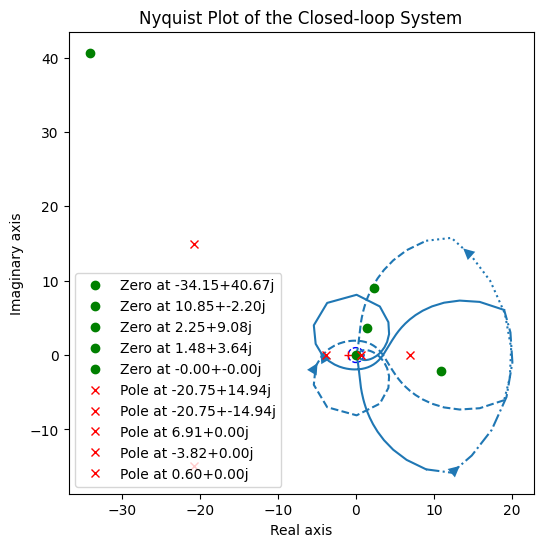

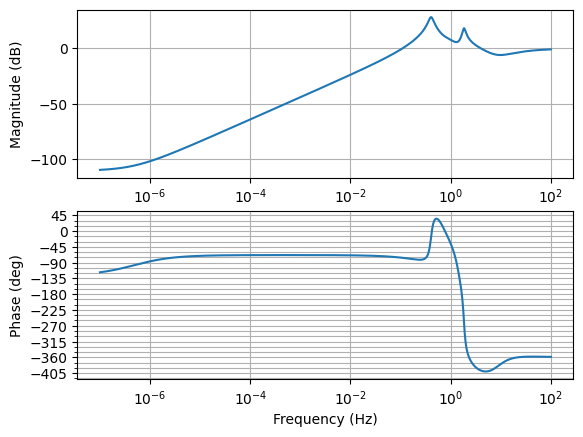

In [ ]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import control as ctrl

magnitude_response = np.abs(positive_H_w)
phase_response = np.degrees(np.angle(positive_H_w))

# 定義擬合函數
def frequency_response_fit(params, freqs, magnitude, phase):
    """
    擬合頻率響應的最小二乘法函數。
    
    :param params: 預測的零點和極點的實部和虛部
    :param freqs: 頻率數據 (rad/s)
    :param magnitude: 幅度響應數據
    :param phase: 相位響應數據
    :return: 頻率響應誤差（包括幅度和相位）
    """

    num_zeros = 5
    num_poles = 5
    
    real_zeros = params[:num_zeros]
    imag_zeros = params[num_zeros:num_zeros + num_zeros]
    
    real_poles = params[num_zeros + num_zeros:num_zeros + num_zeros + num_poles]
    imag_poles = params[num_zeros + num_zeros + num_poles:num_zeros + num_zeros + num_poles + num_poles]
    
    zeros = real_zeros + 1j * imag_zeros
    poles = real_poles + 1j * imag_poles

    H_model = np.ones_like(freqs, dtype=complex)
    
    for z in zeros:
        H_model *= (1j * freqs - z)
    for p in poles:
        H_model /= (1j * freqs - p)

    magnitude_model = np.abs(H_model)
    phase_model = np.angle(H_model)

    magnitude_error = magnitude_model - magnitude
    phase_error = (np.angle(np.exp(1j * (phase_model - phase))) * 180 / np.pi)

    return np.concatenate([magnitude_error, phase_error])

# 初始猜測零點和極點（實部和虛部分開）
initial_real_zeros = np.array([1, 1, 1, 1, 1])  # 假設零點實部
initial_imag_zeros = np.array([1, -1, 0.5, -0.5, 0.2])  # 假設零點虛部
initial_real_poles = np.array([-1, -1, -1, -1, -1])  # 假設極點實部
initial_imag_poles = np.array([0.5, -0.5, 0.3, -0.3, 0.1])  # 假設極點虛部

initial_params = np.concatenate([initial_real_zeros, initial_imag_zeros, initial_real_poles, initial_imag_poles])

result = least_squares(frequency_response_fit, initial_params, args=(positive_freqs, magnitude_response, phase_response))

fitted_real_zeros = result.x[:5]
fitted_imag_zeros = result.x[5:10]
fitted_real_poles = result.x[10:15]
fitted_imag_poles = result.x[15:] 

print("Fitted Zeros:", fitted_real_zeros + 1j * fitted_imag_zeros)
print("Fitted Poles:", fitted_real_poles + 1j * fitted_imag_poles)

fitted_zeros = fitted_real_zeros + 1j * fitted_imag_zeros
fitted_poles = fitted_real_poles + 1j * fitted_imag_poles

num = np.poly(fitted_zeros)
den = np.poly(fitted_poles)
sys_fitted = ctrl.TransferFunction(num, den)

print("Fitted Transfer Function:")
print(sys_fitted)

# ----------  Nyquist  ----------
plt.figure(figsize=(6, 6))
ctrl.nyquist(sys_fitted)
plt.title("Nyquist Plot of the Closed-loop System")

zeros = sys_fitted.zeros().tolist()
poles = sys_fitted.poles().tolist()
for zero in zeros:
    plt.plot(zero.real, zero.imag, 'go', label=f'Zero at {zero.real:.2f}+{zero.imag:.2f}j')
for pole in poles:
    plt.plot(pole.real, pole.imag, 'rx', label=f'Pole at {pole.real:.2f}+{pole.imag:.2f}j')

unit_circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

plt.legend()
plt.grid()
plt.show()

# bode plot
ctrl.bode(sys_fitted, dB=True, Hz=True)
plt.show()